# O$_2$scl interpolation example for O$_2$sclpy

See the O$_2$sclpy documentation at
https://neutronstars.utk.edu/code/o2sclpy for more information.

In [30]:
import o2sclpy
import matplotlib.pyplot as plot
import sys
import math
import numpy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

plots=True
if 'pytest' in sys.modules:
    plots=False

Link the o2scl library:

In [31]:
link=o2sclpy.linker()
link.link_o2scl()

Create a sample function to interpolate:

In [32]:
def f(x):
    return math.sin(1.0/(0.3+x))

Create sample data from our function:

In [33]:
xa=[0 for i in range(0,20)]
ya=[0 for i in range(0,20)]
for i in range(0,20):
    if i>0:
        xa[i]=xa[i-1]+((i)/40)**2
    ya[i]=math.sin(1.0/(0.3+xa[i]))

Compute the mean and standard deviation so that we can normalize the data:

In [34]:
m=numpy.mean(ya)
s=numpy.std(ya,ddof=1)
print('mean: %7.6e, std: %7.6e' % (m,s))
ya2=[(ya[i]-m)/s for i in range(0,20)]

mean: 5.008483e-01, std: 4.304529e-01


Copy the data into ``std_vector`` objects:

In [35]:
xp=o2sclpy.std_vector(link)
yp=o2sclpy.std_vector(link)
xp.resize(20)
yp.resize(20)
for i in range(0,20):
    xp[i]=xa[i]
    yp[i]=ya2[i]

Create the interpolators:

In [36]:
iv_lin=o2sclpy.interp_vec(link)
iv_lin.set(20,xp,yp,o2sclpy.itp_linear)
iv_csp=o2sclpy.interp_vec(link)
iv_csp.set(20,xp,yp,o2sclpy.itp_cspline)
iv_aki=o2sclpy.interp_vec(link)
iv_aki.set(20,xp,yp,o2sclpy.itp_akima)
iv_mon=o2sclpy.interp_vec(link)
iv_mon.set(20,xp,yp,o2sclpy.itp_monotonic)
iv_stef=o2sclpy.interp_vec(link)
iv_stef.set(20,xp,yp,o2sclpy.itp_steffen)
iv_ko=o2sclpy.interp_krige_optim(link)
iv_ko.set(20,xp,yp,True)

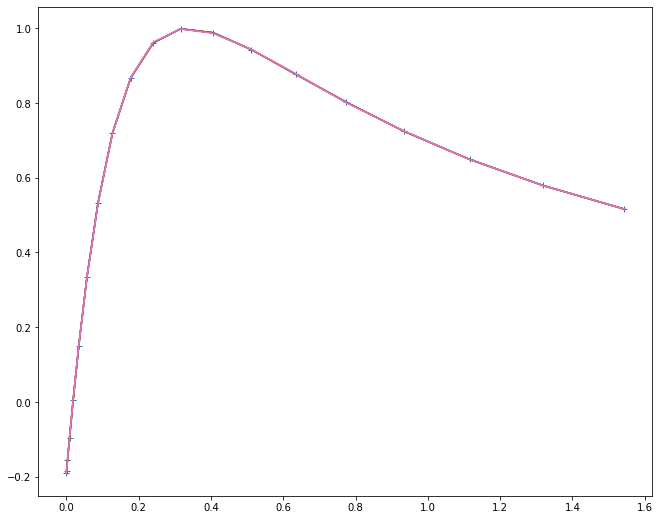

In [37]:
plot.plot(xa,ya,lw=0,marker='+')
plot.plot(xa,[iv_lin.eval(xa[i])*s+m for i in range(0,20)])
plot.plot(xa,[iv_csp.eval(xa[i])*s+m for i in range(0,20)])
plot.plot(xa,[iv_aki.eval(xa[i])*s+m for i in range(0,20)])
plot.plot(xa,[iv_mon.eval(xa[i])*s+m for i in range(0,20)])
plot.plot(xa,[iv_stef.eval(xa[i])*s+m for i in range(0,20)])
plot.plot(xa,[iv_ko.eval(xa[i])*s+m for i in range(0,20)])

In [38]:
max=xa[19]
xb=[i/2000.0*max for i in range(0,2001)]

In [39]:
xa2=numpy.array(xa).reshape(-1,1)

Create a Gaussian process from sklearn to perform the interpolation. Like the O$_2$scl class interp_krige_optim, this is a simple one-parameter version which only varies the length scale.

In [40]:
kernel=RBF(1.0,(1.0e-2,1.0e2))
gpr=GaussianProcessRegressor(kernel=kernel).fit(xa2,ya)

for hyperparameter in gpr.kernel_.hyperparameters:
    print('hp',hyperparameter)
params = gpr.kernel_.get_params()
for key in sorted(params):
    print("kp: %s : %s" % (key, params[key]))
params2=gpr.get_params()
for key in sorted(params2):
    print("gpp: %s : %s" % (key, params2[key]))

hp Hyperparameter(name='length_scale', value_type='numeric', bounds=array([[1.e-02, 1.e+02]]), n_elements=1, fixed=False)
kp: length_scale : 0.131209933688579
kp: length_scale_bounds : (0.01, 100.0)
gpp: alpha : 1e-10
gpp: copy_X_train : True
gpp: kernel : RBF(length_scale=1)
gpp: kernel__length_scale : 1.0
gpp: kernel__length_scale_bounds : (0.01, 100.0)
gpp: n_restarts_optimizer : 0
gpp: normalize_y : False
gpp: optimizer : fmin_l_bfgs_b
gpp: random_state : None


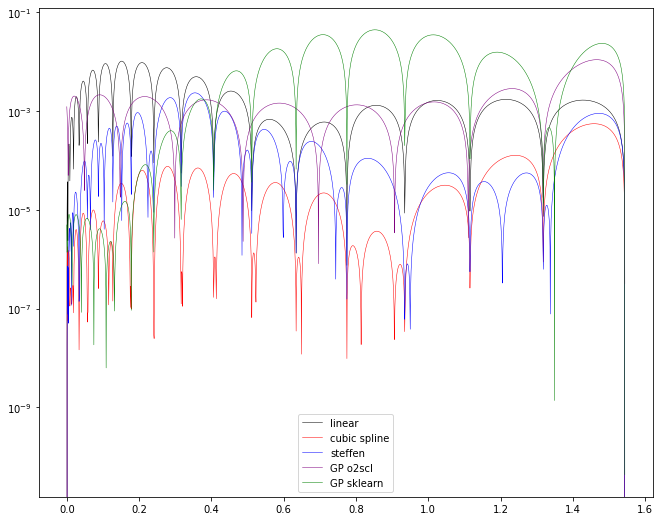

In [41]:
plot.rcParams['figure.figsize'] = [11, 9]
plot.semilogy(xb,[abs(f(xb[i])-(iv_lin.eval(xb[i])*s+m)) 
                  for i in range(0,2001)],color='black',lw=0.5,label='linear')
plot.semilogy(xb,[abs(f(xb[i])-(iv_csp.eval(xb[i])*s+m)) 
                  for i in range(0,2001)],color='red',lw=0.5,label='cubic spline')
plot.semilogy(xb,[abs(f(xb[i])-(iv_stef.eval(xb[i])*s+m)) 
                  for i in range(0,2001)],color='blue',lw=0.5,label='steffen')
plot.semilogy(xb,[abs(f(xb[i])-(iv_ko.eval(xb[i])*s+m)) 
                  for i in range(0,2001)],color='purple',lw=0.5,label='GP o2scl')
plot.semilogy(xb,[abs(f(xb[i])-(gpr.predict(numpy.array(xb[i]).reshape(-1,1)))) 
                  for i in range(0,2001)],color='green',lw=0.5,label='GP sklearn')
plot.legend()